# Guest Lecture for Q355: Recurrent Nets
## by Eduardo Izquierdo, April 4th, 2022

# Part I: Dynamical Recurrent Neural Networks (DRNNs)

In [12]:
import numpy as np

def sigmoid(x):
    return 1/(1+np.exp(-x))

class CTRNN():

    def __init__(self, size):
        self.Size = size                        # number of neurons in the circuit
        self.States = np.zeros(size)            # state of the neurons
        self.TimeConstants = np.ones(size)      # time-constant for each neuron
        self.invTimeConstants = 1.0/self.TimeConstants
        self.Biases = np.zeros(size)            # bias for each neuron
        self.Weights = np.zeros((size,size))    # connection weight for each pair of neurons
        self.Outputs = np.zeros(size)           # neuron outputs
        self.Inputs = np.zeros(size)            # external input to each neuron

    def randomizeParameters(self):
        self.Weights = np.random.uniform(-10,10,size=(self.Size,self.Size))
        self.Biases = np.random.uniform(-10,10,size=(self.Size))
        self.TimeConstants = np.random.uniform(0.1,5.0,size=(self.Size))
        self.invTimeConstants = 1.0/self.TimeConstants

    def initializeState(self, s):
        self.States = s
        self.Outputs = sigmoid(self.States+self.Biases)

    def step(self, dt):
        netinput = self.Inputs + np.dot(self.Weights.T, self.Outputs)
        self.States += dt * (self.invTimeConstants*(-self.States+netinput))
        self.Outputs = sigmoid(self.States+self.Biases)

## Simulate a random neural network 


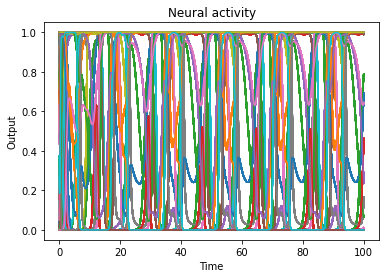

In [18]:
import matplotlib.pyplot as plt

size = 50
duration = 100
stepsize = 0.01

time = np.arange(0.0,duration,stepsize)

nn = CTRNN(size)

nn.randomizeParameters()

nn.initializeState(np.zeros(size))

outputs = np.zeros((len(time),size))

# Run simulation
step = 0
for t in time:
    nn.step(stepsize)
    outputs[step] = nn.Outputs
    step += 1

# Plot activity
for i in range(size):
    plt.plot(time,outputs)
plt.xlabel("Time")
plt.ylabel("Output")
plt.title("Neural activity")
plt.show()

# Part II: Evolutionary Algorithms (EAs)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class Microbial():

    def __init__(self, fitnessFunction, popsize, genesize, recombProb, mutatProb, demeSize, generations):
        self.fitnessFunction = fitnessFunction
        self.popsize = popsize
        self.genesize = genesize
        self.recombProb = recombProb
        self.mutatProb = mutatProb
        self.demeSize = int(demeSize/2)
        self.generations = generations
        self.tournaments = generations*popsize
        self.pop = np.random.rand(popsize,genesize)*2 - 1
        self.fitness = np.zeros(popsize)
        self.avgHistory = np.zeros(generations)
        self.bestHistory = np.zeros(generations)
        self.gen = 0

    def showFitness(self):
        plt.plot(self.bestHistory)
        plt.plot(self.avgHistory)
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
        plt.title("Best and average fitness")
        plt.show()

    def fitStats(self):
        bestind = self.pop[np.argmax(self.fitness)]
        bestfit = np.max(self.fitness)
        avgfit = np.mean(self.fitness)
        self.avgHistory[self.gen]=avgfit
        self.bestHistory[self.gen]=bestfit
        return avgfit, bestfit, bestind

    def run(self):
        # Calculate all fitness once
        for i in range(self.popsize):
            self.fitness[i] = self.fitnessFunction(self.pop[i])
        # Evolutionary loop
        for g in range(self.generations):
            self.gen = g
            # Report statistics every generation
            self.fitStats()
            for i in range(self.popsize):
                # Step 1: Pick 2 individuals
                a = np.random.randint(0,self.popsize-1)
                b = np.random.randint(a-self.demeSize,a+self.demeSize-1)%self.popsize   ### Restrict to demes
                while (a==b):   # Make sure they are two different individuals
                    b = np.random.randint(a-self.demeSize,a+self.demeSize-1)%self.popsize   ### Restrict to demes
                # Step 2: Compare their fitness
                if (self.fitness[a] > self.fitness[b]):
                    winner = a
                    loser = b
                else:
                    winner = b
                    loser = a
                # Step 3: Transfect loser with winner --- Could be made more efficient using Numpy
                for l in range(self.genesize):
                    if (np.random.random() < self.recombProb):
                        self.pop[loser][l] = self.pop[winner][l]
                # Step 4: Mutate loser and make sure new organism stays within bounds
                self.pop[loser] += np.random.normal(0.0,self.mutatProb,size=self.genesize)
                self.pop[loser] = np.clip(self.pop[loser],-1,1)
                # Save fitness
                self.fitness[loser] = self.fitnessFunction(self.pop[loser])

# Part III: Using an EA to train a DRNN

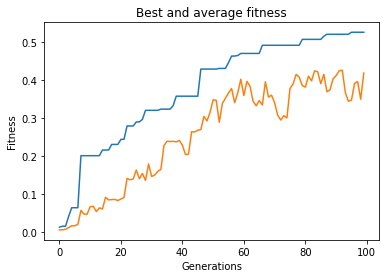

In [19]:
popsize = 10
size = 3
genesize = size*size + size*2
recombProb = 0.5
mutatProb = 1/genesize
generations = 100
demeSize = 2

weightrange = 10
biasrange = 10
duration = 50
stepsize = 0.01
time = np.arange(0.0,duration,stepsize)

def fitnessFunction(genotype):
    nn = CTRNN(size)

    # Map from Genotype to Phenotype
    weights = genotype[0:size*size] * weightrange
    nn.Weights = weights.reshape((size,size))
    nn.Biases = genotype[size*size:size*size + size] * biasrange
    nn.TimeConstants = genotype[size*size + size:] + 2.0
    nn.invTimeConstants = 1.0/nn.TimeConstants

    nn.initializeState(np.zeros(size))
    outputs = np.zeros((len(time),size))

    # Run simulation
    step = 0
    for t in time:
        nn.step(stepsize)
        outputs[step] = nn.Outputs
        step += 1

    # Sum the absolute rate of change of all neurons across time as a proxy for "active"
    activity = np.sum(np.abs(np.diff(outputs.T)))/(duration*size)

    return activity

### Evolve
ga = Microbial(fitnessFunction, popsize, genesize, recombProb, mutatProb, demeSize, generations)
ga.run()
ga.showFitness()
avgfit, bestfit, genotype = ga.fitStats()

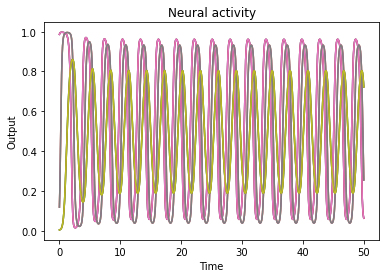

In [20]:
nn = CTRNN(size)

# Map from Genotype to Phenotype
weights = genotype[0:size*size] * weightrange
nn.Weights = weights.reshape((size,size))
nn.Biases = genotype[size*size:size*size + size] * biasrange
nn.TimeConstants = genotype[size*size + size:] + 2.0
nn.invTimeConstants = 1.0/nn.TimeConstants

nn.initializeState(np.zeros(size))
outputs = np.zeros((len(time),size))

# Run simulation
step = 0
for t in time:
    nn.step(stepsize)
    outputs[step] = nn.Outputs
    step += 1

# Plot activity
for i in range(size):
    plt.plot(time,outputs)
plt.xlabel("Time")
plt.ylabel("Output")
plt.title("Neural activity")
plt.show()